# TP: Support Vector Machines (SVM) & kernel methods

Notebook heavily inspired by [Chloé-Agathe Azencott](http://cazencott.info) and Matthieu Najm's notebooks, upgraded by Gwenn Guichaoua.

In this notebook, we aim to explore SVMs (support vector machines) linear and kernel-based (non-linear).

We will try to predict the species of a penguin from its physical characteristics using support vector machines (SVM).
For this we will use the *palmerpenguins* dataset, an alternative to the now classic *iris* of scikit-learn. It contains the characteristics of three species of penguins found on the Palmer Archipelago, off the northwest coast of the Antarctic Peninsula.
For more information, you can visit the website: https://allisonhorst.github.io/palmerpenguins/index.html

In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections

In [134]:
# load numpy as np, matplotlib as plt
%matplotlib inline

In [135]:
plt.rc('font', **{'size': 12}) # sets the font size globally for plots (in pt)

## 1. Loading data

We will try to predict the species of a penguin from its physical characteristics using Support Vector Machines (SVM).

For this we will use the *palmerpenguins* dataset, an alternative to the now classic *iris* from scikit-learn.

For more information, you can visit the site: https://allisonhorst.github.io/palmerpenguins/index.html

It contains the characteristics of three penguin species recorded on the Palmer Archipelago, off the northwest coast of the Antarctic Peninsula.

In [136]:
# You might need to adjust the path
palmerpenguins = pd.read_csv("penguins_data.csv")

__Alternatively:__ If you need to download the file (e.g. on colab):

In [137]:
# !wget https://raw.githubusercontent.com/chagaz/cp-ia-intro-ml-2022/main/4-SVM/data/penguins_data.csv
# palmerpenguins = pd.read_csv("penguins_data.csv")

In [138]:
palmerpenguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


### Data Description

In [139]:
print(palmerpenguins.shape)

(344, 8)


In [140]:
print(collections.Counter(palmerpenguins.species))

Counter({'Adelie': 152, 'Gentoo': 124, 'Chinstrap': 68})


**344** penguins with **8** attributes:
- *species*: Adelie (152 penguins), Gentoo (124 penguins) and Ginstrap (68 penguins)
- *island*: Biscoe, Dream and Torgersen
- *bill_length_mm*: bill length in mm
- *bil_depth_mm*: bill width in mm
- *flipper_length_mm*: flipper width in mm
- *body_mass_g*: weight in g
- *sex*: male and female
- *year*: year of census

### Missing data

In [141]:
palmerpenguins.isnull().sum()

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
year                  0
dtype: int64

You notice that there are some observations for which information is missing. This is called **missing data** (or **missing values**).
Here we decide to ignore these observations.

In [142]:
palmerpenguins = palmerpenguins[palmerpenguins['bill_depth_mm'].notna()]
palmerpenguins = palmerpenguins.reset_index(drop=True)
palmerpenguins.shape

(342, 8)

So we only have 342 samples left.

Instead of ignoring incomplete observations, a solution that often turns out to be better (from the point of view of the performance of decision models built from the data) is to **estimate** (or **impute**) the missing data and to treat the estimated values ​​as measured values.

For this we could have used the ```SimpleImputer function``` of ```sklearn.impute```. For more information, you can go to the site: https://scikit-learn.org/stable/modules/impute.html#impute

### Variables

Subsequently, we will only be interested in the numeric variables *bill_depth_mm*, *bill_length_mm*, *flipper_length_mm* and *body_mass_g*.

In [143]:
penguins_features = palmerpenguins[["bill_length_mm", "bill_depth_mm","body_mass_g", "flipper_length_mm"]]

### Labels

We will try to predict the species, which corresponds to **species** but as integers. It will then be easier to handle the species as integers than as text.

In [144]:
species_names, species_int = np.unique(palmerpenguins.species, return_inverse=True)
print(species_names)

['Adelie' 'Chinstrap' 'Gentoo']


In [145]:
penguins_labels = pd.DataFrame(palmerpenguins["species"])
penguins_labels["species_int"] = species_int

In [146]:
penguins_labels

,species,species_int
0,Adelie,0
1,Adelie,0
2,Adelie,0
3,Adelie,0
4,Adelie,0
...,...,...
337,Chinstrap,1
338,Chinstrap,1
339,Chinstrap,1
340,Chinstrap,1


## 2. Linear SVM (linearly separable case)

Here we will limit ourselves to two species: *Adelie (0)* and *Gentoo (2)* and two variables: *bill_length_mm* and *bill_depth_mm*.

### Restricting data to the two variables and two chosen labels

In [147]:
labels = penguins_labels[penguins_labels["species_int"].isin([0,2])]
labels = np.array(labels["species_int"])
print("shape de y:", labels.shape)

data = penguins_features[penguins_labels["species_int"].isin([0,2])] 
data = np.array(data[["bill_depth_mm", "bill_length_mm"]])
print("shape de X:", data.shape)

shape de y: (274,)
shape de X: (274, 2)


### Data Visualisation 

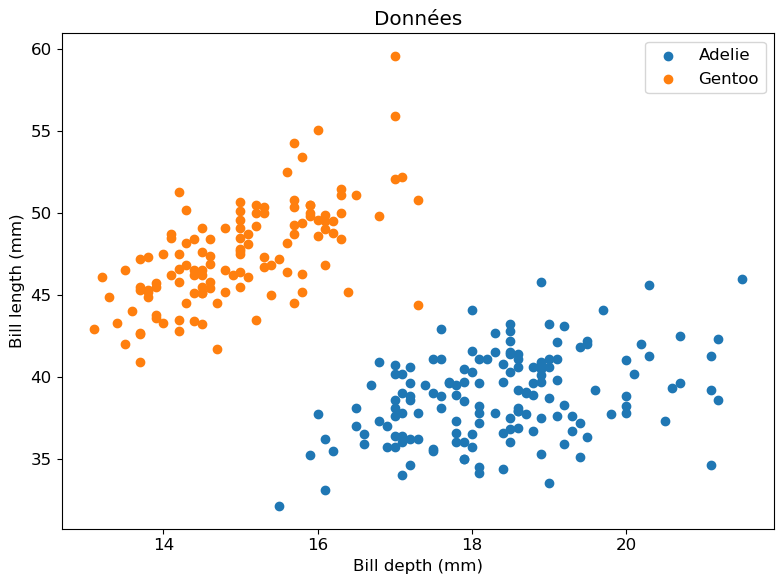

In [148]:
plt.figure(figsize=(8, 6))

# afficher les données (pingouins Adelie)
adelie_indices = np.where(labels==0)[0]
adelie = plt.scatter(data[adelie_indices][:, 0], 
                    data[adelie_indices][:, 1], 
                    label = 'Adelie')

# afficher les données (pingouins Gentoo)
gentoo_indices = np.where(labels==2)[0]
gentoo = plt.scatter(data[gentoo_indices][:, 0], 
                    data[gentoo_indices][:, 1], 
                    label = 'Gentoo')

# Légende
plt.legend()
plt.xlabel("Bill depth (mm)")
plt.ylabel("Bill length (mm)")
plt.title("Données")
plt.tight_layout()

### Q1
__Question 1:__ Does the classification problem seem easy or difficult to you? Will you be able to train a linear model?

__Answer:__ Yes, we can imagine a linear decision boundary visually separating these two classes.

### Linear SVM

We will use the [SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) class from the `svm` module of scikit-learn to train a linear SVM on this data.

In [149]:
from sklearn import svm

In [150]:
# initialisation
model_svc = svm.SVC(kernel='linear', C=10)

# training
model_svc.fit(data, labels)

SVC(C=10, kernel='linear')

Let's display the predictor's performance:

In [151]:
print(f"Linear SVM score(C=10): {model_svc.score(data, labels):.3f}")

Linear SVM score(C=10): 1.000


### Q2

__Question 2:__ What score is this? You can use ```help(model_svc.score)```

__Answer 2:__ Accuracy, i.e. proportion of correctly predicted labels.

### Q3
__Question 3:__ What does this performance mean?

__Answer 3:__ Accuracy equal to 1 means that all labels were predicted correctly, the model perfectly explains the data (though still may be overfitted, more on this below).

We can also display the confusion matrix:

In [152]:
from sklearn import metrics

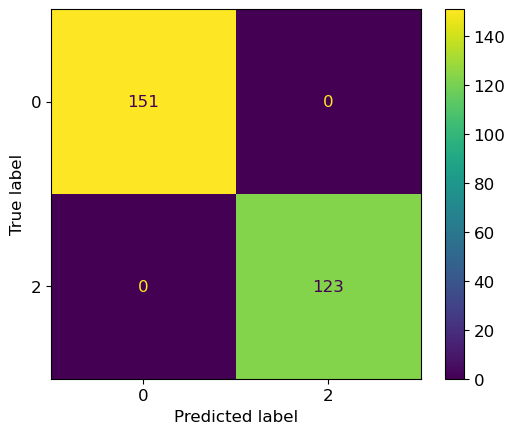

In [153]:
metrics.ConfusionMatrixDisplay.from_predictions(labels, model_svc.predict(data))

Alternatively:

In [154]:
metrics.confusion_matrix(labels, model_svc.predict(data))

array([[151,   0],
       [  0, 123]])

### Separating hyperplane

We can now visualize the decision boundary:

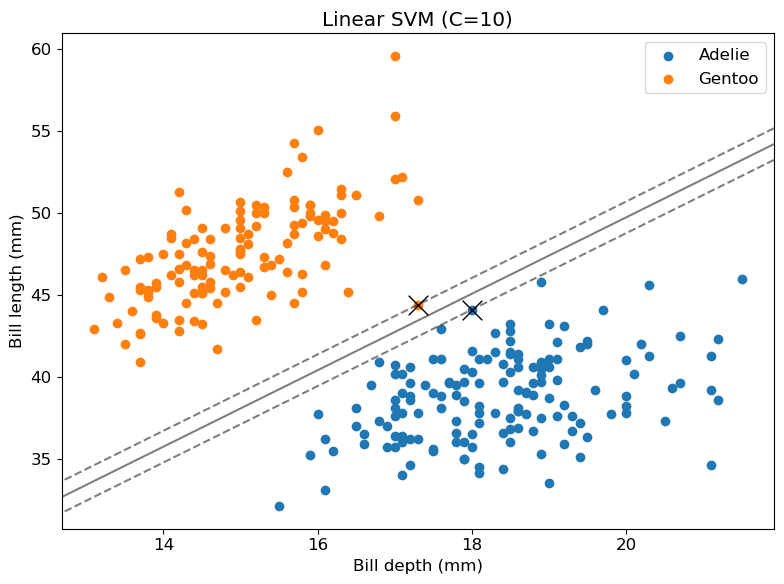

In [155]:
plt.figure(figsize=(8, 6))

# show data (Adelie penguins)
adelie_indices = np.where(labels==0)[0]
adelie = plt.scatter(data[adelie_indices][:, 0], 
                    data[adelie_indices][:, 1], 
                    label = 'Adelie')

# show data (Gentoo penguins)
gentoo_indices = np.where(labels==2)[0]
gentoo = plt.scatter(data[gentoo_indices][:, 0], 
                    data[gentoo_indices][:, 1], 
                    label = 'Gentoo')

# Frame limits
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Mark the support vectors with a cross
ax.scatter(model_svc.support_vectors_[:, 0], 
           model_svc.support_vectors_[:, 1], 
           linewidth=1, 
           marker='x', s=200,
           color='k')

# Grid of points on which to apply the model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
# Prédire pour les points de la grille
Z = model_svc.decision_function(xy).reshape(XX.shape)

# Show decision boundary and margin
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], 
           alpha=0.5, linestyles=['--', '-', '--'])


plt.legend()
plt.xlabel("Bill depth (mm)")
plt.ylabel("Bill length (mm)")
plt.title("Linear SVM (C=10)")
plt.tight_layout()

### Q4
__Question 4:__ Which points are support vectors?

__Answer 4:__ Two points marked by crosses, lying on the margin boundaries.

### With smaller C

### Q5
__Question 5:__ What can we expect with a lower C value?

__Answer 5:__ The model will be more regularized (when in doubt, check the course and scikit-learn documentation). Missclassifications will be less punished and the margin should increase.

Let's check this in practice:

In [156]:
# initialisation 
model_svc_01 = svm.SVC(kernel='linear', C=0.1)

# training
model_svc_01.fit(data, labels)

SVC(C=0.1, kernel='linear')

Let's display the predictor's performance:

In [157]:
print(f"Linear SVM score (C=0.1): {model_svc_01.score(data, labels):.3f}")

Linear SVM score (C=0.1): 0.996


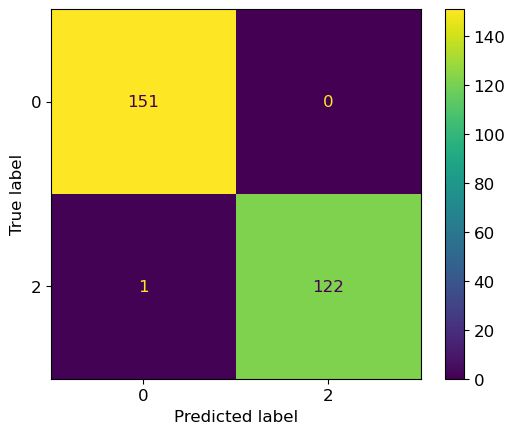

In [158]:
metrics.ConfusionMatrixDisplay.from_predictions(labels, model_svc_01.predict(data))

Alternatively :

In [159]:
metrics.confusion_matrix(labels, model_svc_01.predict(data))

array([[151,   0],
       [  1, 122]])

Let's visualize the new decision frontier:

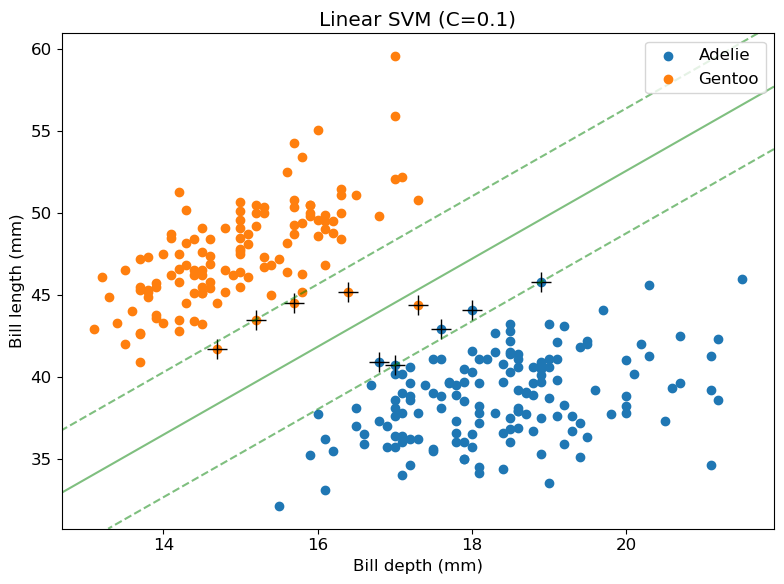

In [160]:
plt.figure(figsize=(8, 6))

adelie_indices = np.where(labels==0)[0]
adelie = plt.scatter(data[adelie_indices][:, 0], 
                    data[adelie_indices][:, 1], 
                    label = 'Adelie')

gentoo_indices = np.where(labels==2)[0]
gentoo = plt.scatter(data[gentoo_indices][:, 0], 
                    data[gentoo_indices][:, 1], 
                    label = 'Gentoo')

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()


xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
# Prédire pour les points de la grille
Z = model_svc.decision_function(xy).reshape(XX.shape)




ax.scatter(model_svc_01.support_vectors_[:, 0], 
           model_svc_01.support_vectors_[:, 1], 
           linewidth=1, 
           marker='+', s=200,
           color='k')


xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T

Z = model_svc_01.decision_function(xy).reshape(XX.shape)


ax.contour(XX, YY, Z, colors='g', levels=[-1, 0, 1], 
           alpha=0.5, linestyles=['--', '-', '--'])


plt.legend()
plt.xlabel("Bill depth (mm)")
plt.ylabel("Bill length (mm)")
plt.title("Linear SVM (C=0.1)")
plt.tight_layout()

## 3. Linear SVM (non-linearly separable case)

Now let's use the two variables *body_mass_g* and *bill_length_mm*.

### Restricting data to the two variables and two chosen labels

In [161]:
labels = penguins_labels[penguins_labels["species_int"].isin([0,2])]
labels = np.array(labels["species_int"])
print("y shape:", labels.shape)

data = penguins_features[penguins_labels["species_int"].isin([0,2])] 
data = np.array(data[["body_mass_g", "bill_length_mm"]])
print("X shape:", data.shape)

y shape: (274,)
X shape: (274, 2)


### Data visualisation

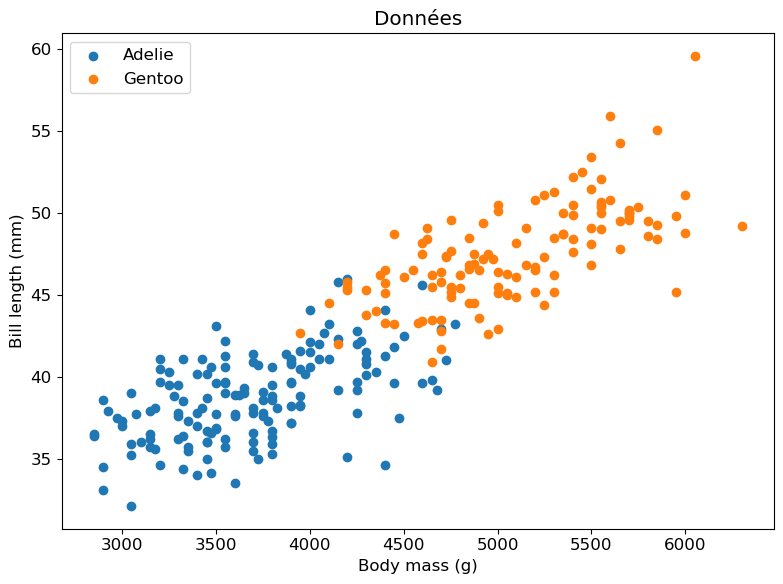

In [162]:
plt.figure(figsize=(8, 6))

# show data (Adelie penguins)
adelie_indices = np.where(labels==0)[0]
adelie = plt.scatter(data[adelie_indices][:, 0], 
                    data[adelie_indices][:, 1], 
                    label = 'Adelie')

# show data (Gentoo penguins)
gentoo_indices = np.where(labels==2)[0]
gentoo = plt.scatter(data[gentoo_indices][:, 0], 
                    data[gentoo_indices][:, 1], 
                    label = 'Gentoo')

# Legend
plt.legend()
plt.xlabel("Body mass (g)")
plt.ylabel("Bill length (mm)")
plt.title("Données")
plt.tight_layout()

### Q6
__Question 6:__ Does the classification problem seem easy or difficult to you? Will you be able to train a linear model?

__Answer 6:__ No, as cloud points are mixed around the borderline, we do not expect that linear SVM would be able to separate them perfectly. However, some high (but not equal to 1) accuracy can be reached.

### Q7
__Question 7:__ What do you think of the scales taken by the two variables?

__Answer 7:__ The scales are very different and could interfere with the classification task (especially the regularization).

### Transforming variables

Now we will center-reduce the data.

In [163]:
from sklearn import preprocessing

In [164]:
# standardization (center-reduce)
std_scaler = preprocessing.StandardScaler().fit(data)
data_scaled = std_scaler.transform(data)

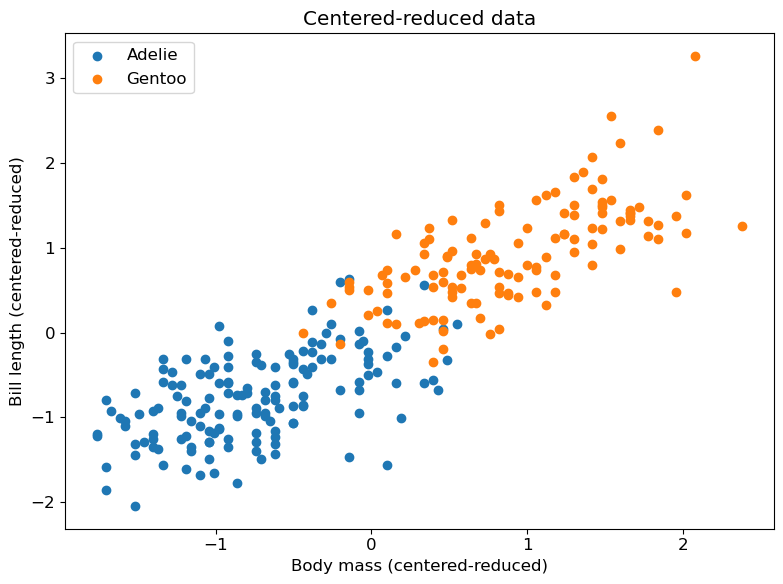

In [165]:
plt.figure(figsize=(8, 6))

#show data (Adelie penguins)
adelie_indices = np.where(labels==0)[0]
adelie = plt.scatter(data_scaled[adelie_indices][:, 0], 
                    data_scaled[adelie_indices][:, 1], 
                    label = 'Adelie')

# show data (Gentoo penguins)
gentoo_indices = np.where(labels==2)[0]
gentoo = plt.scatter(data_scaled[gentoo_indices][:, 0], 
                    data_scaled[gentoo_indices][:, 1], 
                    label = 'Gentoo')

# Legend
plt.legend()
plt.xlabel("Body mass (centered-reduced)")
plt.ylabel("Bill length (centered-reduced)")
plt.title("Centered-reduced data")
plt.tight_layout()

### Linear SVM

In [166]:
# initialisation
model_svc = svm.SVC(kernel='linear', C=10)

# training
model_svc.fit(data_scaled, labels)

SVC(C=10, kernel='linear')

Let's display the predictor's performance:

In [167]:
print(f"Linear SVM score (C=10): {model_svc.score(data_scaled, labels):.3f}")

Linear SVM score (C=10): 0.964


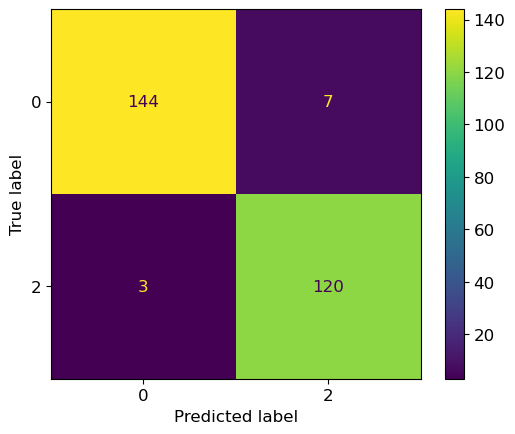

In [168]:
metrics.ConfusionMatrixDisplay.from_predictions(labels, model_svc.predict(data_scaled))

Alternatively :

In [169]:
metrics.confusion_matrix(labels, model_svc.predict(data_scaled))

array([[144,   7],
       [  3, 120]])

### Q8
__Question 8:__ Does this performance meet your expectations?

__Answer 8:__ Yes, there are some missclassification but overall the classes are separable.

### Separating hyperplane

We can now visualize the decision boundary:

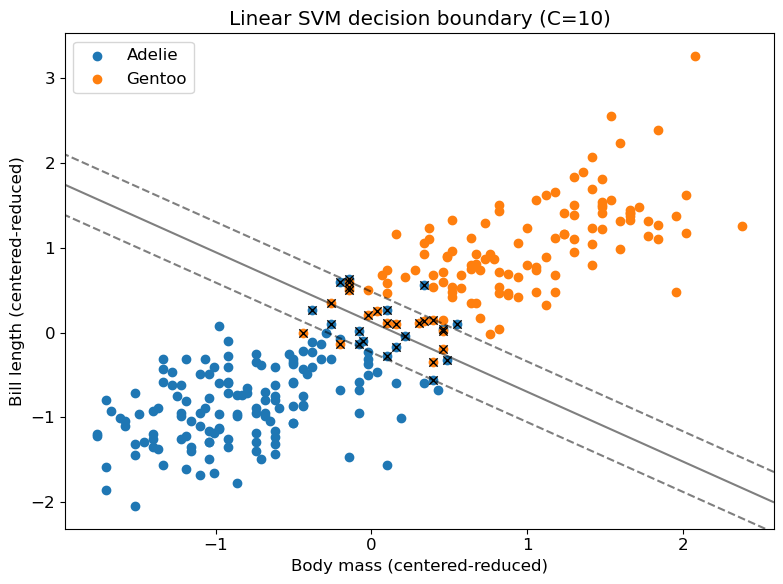

In [170]:
plt.figure(figsize=(8, 6))

# show data (Adelie penguins)
adelie_indices = np.where(labels==0)[0]
adelie = plt.scatter(data_scaled[adelie_indices][:, 0], 
                    data_scaled[adelie_indices][:, 1], 
                    label = 'Adelie')

# show data (Gentoo penguins)
gentoo_indices = np.where(labels==2)[0]
gentoo = plt.scatter(data_scaled[gentoo_indices][:, 0], 
                    data_scaled[gentoo_indices][:, 1], 
                    label = 'Gentoo')


# Frame limits
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Mark the support vectors with a cross
ax.scatter(model_svc.support_vectors_[:, 0], 
           model_svc.support_vectors_[:, 1], 
           linewidth=1, 
           marker='x', 
           color='k')

# Grid of points on which to apply the model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
# Predict for the grid points
Z = model_svc.decision_function(xy).reshape(XX.shape)

# Show decision boundary and margin
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], 
           alpha=0.5, linestyles=['--', '-', '--'])

# Legend
plt.legend()
plt.xlabel("Body mass (centered-reduced)")
plt.ylabel("Bill length (centered-reduced)")
plt.title("Linear SVM decision boundary (C=10)")
plt.tight_layout()

### Q9 
__Question 9:__ Which points are support vectors?

__Answer 9:__ The points with crosses.

### With smaller C

### Q10
__Question 10:__ What can we expect with a lower C value?

__Answer 10:__ A more regularized model, with potentially more missclassifications and wider margins.

Let's check this in practice:

In [171]:
# initialisation
model_svc_01 = svm.SVC(kernel='linear', C=0.01)

# training
model_svc_01.fit(data_scaled, labels)

SVC(C=0.01, kernel='linear')

In [172]:
print(f"Linear SVM score (centered-reduced data, C=0.01): {model_svc_01.score(data_scaled, labels):.3f}")

Linear SVM score (centered-reduced data, C=0.01): 0.964


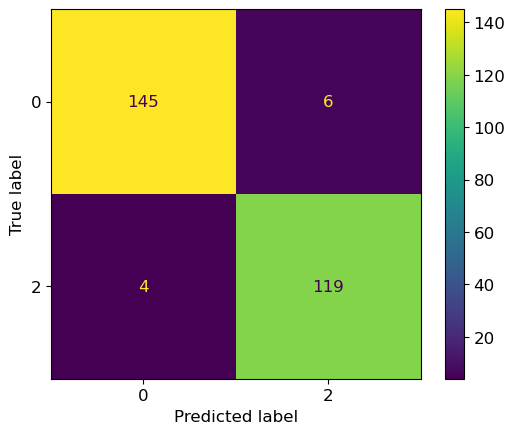

In [173]:
metrics.ConfusionMatrixDisplay.from_predictions(labels, model_svc_01.predict(data_scaled))

Alternatively:

In [174]:
metrics.confusion_matrix(labels, model_svc_01.predict(data_scaled))

array([[145,   6],
       [  4, 119]])

### Q 11
__Question 11:__ How has performance evolved?

__Answer 11:__ The vectors missclassified are probably not the same, but the accuracy hasn't changed.

We can now visualize the decision boundary:

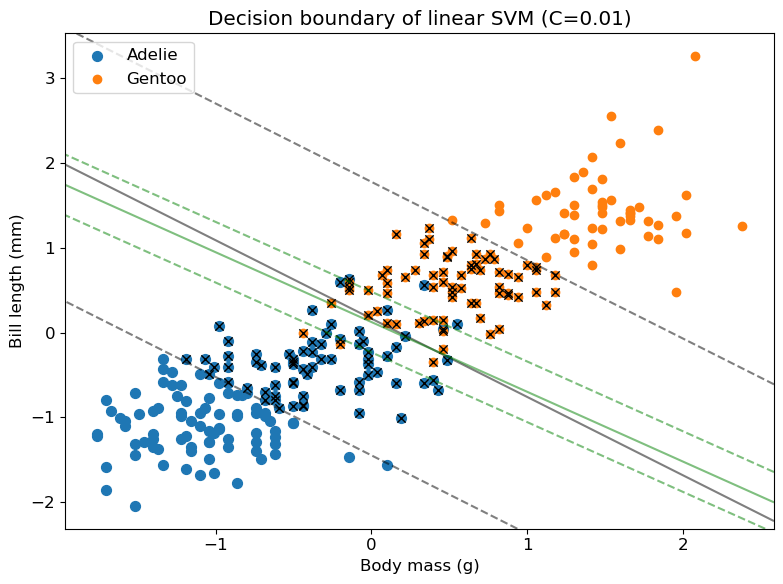

In [175]:
plt.figure(figsize=(8, 6))

# show data (Adelie penguins)
adelie = plt.scatter(data_scaled[np.where(penguins_labels["species_int"]==0),0], 
                    data_scaled[np.where(penguins_labels["species_int"]==0),1], 
                    s=50, 
                    label = 'Adelie')

# show data (Gentoo penguins)
gentoo = plt.scatter(data_scaled[np.where(penguins_labels["species_int"]==2),0], 
                    data_scaled[np.where(penguins_labels["species_int"]==2),1], 
                    label = 'Gentoo')

# Frame limits
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Mark the support vectors with a cross
ax.scatter(model_svc_01.support_vectors_[:, 0], 
           model_svc_01.support_vectors_[:, 1], 
           linewidth=1, 
           marker='x', 
           color='k')

# Grid of points on which to apply the model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
# Predict for the grid points
Z = model_svc_01.decision_function(xy).reshape(XX.shape)

# Show decision boundary and margin
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], 
           alpha=0.5, linestyles=['--', '-', '--'])

# Previous border
# Grid of points on which to apply the model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
# Predict for the grid points
Z = model_svc.decision_function(xy).reshape(XX.shape)

# Show decision boundary and margin
ax.contour(XX, YY, Z, colors='g', levels=[-1, 0, 1], 
           alpha=0.5, linestyles=['--', '-', '--'])


# Legend
plt.legend()
plt.xlabel("Body mass (g)")
plt.ylabel("Bill length (mm)")
plt.title("Decision boundary of linear SVM (C=0.01)")
plt.tight_layout()

## 4. Gram Matrix

The **kernel** (or **Gram matrix**) can be interpreted as a similarity matrix between the different observations. We then rely on the resemblance of certain observations to be able to classify them.

We will represent the Gram matrix associated with the previous classifier. In the case of a linear kernel SVM, this is the scalar product of the variables. So that you can correctly intuit the similarity between the observations, we will reduce ourselves to a matrix with 1s on the diagonal using the *center_an_normalise_kernel()* function.

In [176]:
def center_and_normalise_kernel(K_temp):
    K_temp = preprocessing.KernelCenterer().fit_transform(K_temp)
    nb_item = K_temp.shape[0]
    K_norm = np.zeros((nb_item, nb_item))
    for i in range(nb_item):
        for j in range(i, nb_item):
            K_norm[i, j] = K_temp[i, j] / np.sqrt(K_temp[i, i] * K_temp[j, j])
            K_norm[j, i] = K_norm[i, j]

    return K_norm

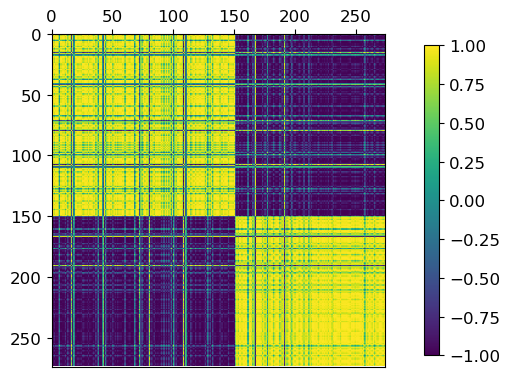

In [177]:
GramMatrix = np.inner(data_scaled, data_scaled)
GramMatrix_scaled = center_and_normalise_kernel(GramMatrix)

# heatmap + color map
fig, ax = plt.subplots(figsize=(5, 5))
plot = ax.imshow(GramMatrix_scaled) 

# set axes boundaries
ax.set_xlim([0, data.shape[0]]) ; ax.set_ylim([0, data_scaled.shape[0]])

# flip the y-axis
ax.invert_yaxis() ; ax.xaxis.tick_top()

# plot colorbar to the right
plt.colorbar(plot, pad=0.1, fraction=0.04)

### Q12
__Question 12:__ What do you notice? Could you have anticipated that the classifier separates well by looking only at the Gram matrix? Notice that the observations are ordered by labels (first the Adelie penguins then the Gentoo).

__Answer 12:__ The two classes are visually distinguishable: vectors within each class are in average closer to each other than to the vectors of the other class. 

What if the classes were random ?

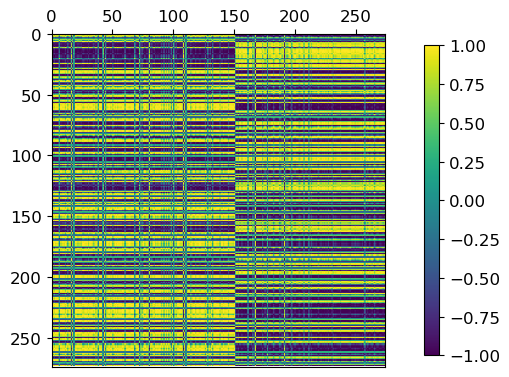

In [178]:
r = GramMatrix.shape[0]
pr = np.random.permutation(np.arange(r))
GramMatrix_shuffle = GramMatrix_scaled[pr,:]


# heatmap + color map
fig, ax = plt.subplots(figsize=(5, 5))
plot = ax.imshow(GramMatrix_shuffle[pr,:]) 

# set axes boundaries
ax.set_xlim([0, data.shape[0]]) ; ax.set_ylim([0, data.shape[0]])

# flip the y-axis
ax.invert_yaxis() ; ax.xaxis.tick_top()

# plot colorbar to the right
plt.colorbar(plot, pad=0.1, fraction=0.04)

### Q13
__Question 13:__ What do you observe? What should we look out for when we observe a Gram matrix?

__Answer 13:__ When the classes are random, we do not observe squares corresponding to them. We would not expect separation to be easy in the random classes case.

## 5. Linear SVM (more difficult case)

Now consider the two species *Adelie (0)* and *Chinstrap (1)* and the variables *body_mass_g* and *bill_depth_mm*.

### Restricting data to the two variables and two chosen labels

In [179]:
labels = penguins_labels[penguins_labels["species_int"].isin([0,1])]
labels = np.array(labels["species_int"])
print("shape de y:", labels.shape)

data = penguins_features[penguins_labels["species_int"].isin([0,1])] 
data = np.array(data[["body_mass_g", "bill_depth_mm"]])
print("shape de X:", data.shape)

shape de y: (219,)
shape de X: (219, 2)


### Transforming variables

Now we will center-reduce the data.

In [180]:
# standardization (center-reduce)
std_scaler = preprocessing.StandardScaler().fit(data)
data_scaled = std_scaler.transform(data)

### Data visualisation

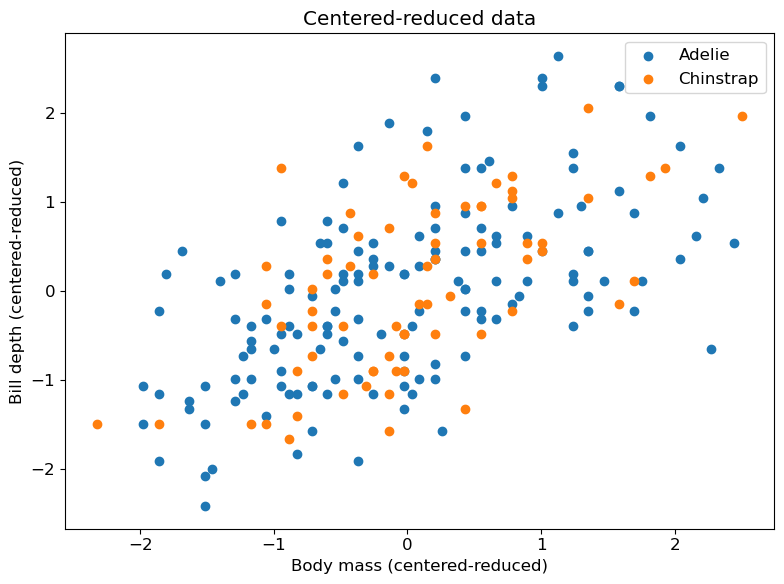

In [181]:
plt.figure(figsize=(8, 6))

# show data (pingouins Adelie)
adelie_indices = np.where(labels==0)[0]
adelie = plt.scatter(data_scaled[adelie_indices][:, 0], 
                    data_scaled[adelie_indices][:, 1], 
                    label = 'Adelie')

# show data (pingouins Gentoo)
gentoo_indices = np.where(labels==1)[0]
gentoo = plt.scatter(data_scaled[gentoo_indices][:, 0], 
                    data_scaled[gentoo_indices][:, 1], 
                    label = 'Chinstrap')

# Legend
plt.legend()
plt.xlabel("Body mass (centered-reduced)")
plt.ylabel("Bill depth (centered-reduced)")
plt.title("Centered-reduced data")
plt.tight_layout()

### Q14
__Question 14:__ Does the classification problem seem easy or difficult to you? Will you be able to train a linear model?

__Answer 14:__ The two classes are highly mixed and not separable with a linear decision boundary, the problem is difficult. It is however always possible to train a model.

### Linear SVM

In [182]:
# initialisation
model_svc = svm.SVC(kernel='linear', C=10)

# training
model_svc.fit(data_scaled, labels)

SVC(C=10, kernel='linear')

Let's display the predictor's performance:

In [183]:
print(f"Linear SVM score (C=10): {model_svc.score(data_scaled, labels):.3f}")

Linear SVM score (C=10): 0.689


# Q15
__Question 15:__ Does this performance meet your expectations?

__Answer 15:__ This accuracy is very low. We could expect a similar accuracy with a random classes assignment in our imbalanced dataset: $151 / (151+68) \approx 0.69$.

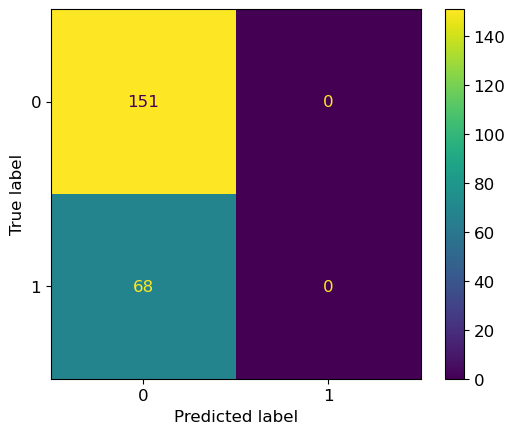

In [184]:
metrics.ConfusionMatrixDisplay.from_predictions(labels, model_svc.predict(data_scaled))

Alternatively :

In [185]:
metrics.confusion_matrix(labels, model_svc.predict(data_scaled))

array([[151,   0],
       [ 68,   0]])

### Q16
__Question 16:__ What did we really learn here?

__Answer 16:__ All the penguins are Adelie.

We can now visualize the decision boundary:

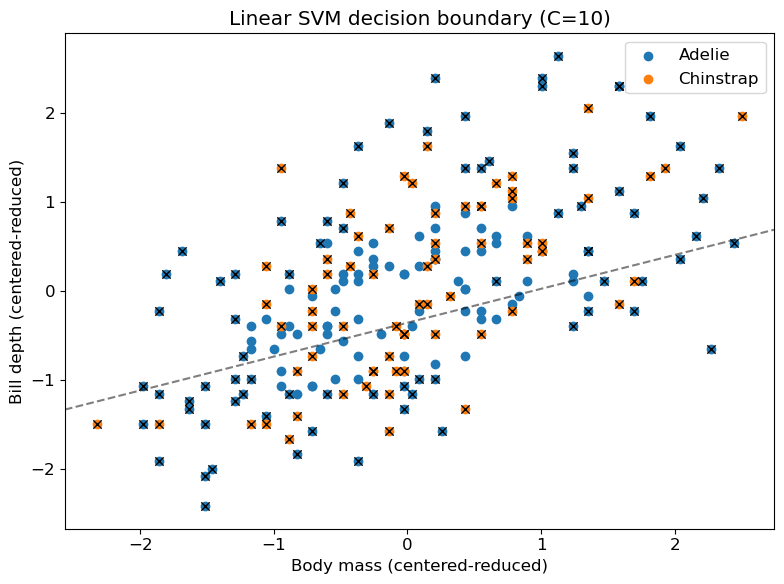

In [186]:
plt.figure(figsize=(8, 6))

# show data (pingouins Adelie)
adelie_indices = np.where(labels==0)[0]
adelie = plt.scatter(data_scaled[adelie_indices][:, 0], 
                    data_scaled[adelie_indices][:, 1], 
                    label = 'Adelie')

# show data (pingouins Gentoo)
gentoo_indices = np.where(labels==1)[0]
gentoo = plt.scatter(data_scaled[gentoo_indices][:, 0], 
                    data_scaled[gentoo_indices][:, 1], 
                    label = 'Chinstrap')


# Frame limits
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Mark the support vectors with a cross
ax.scatter(model_svc.support_vectors_[:, 0], 
           model_svc.support_vectors_[:, 1], 
           linewidth=1, 
           marker='x', 
           color='k')

# Grid of points on which to apply the model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
# Predict for the grid points
Z = model_svc.decision_function(xy).reshape(XX.shape)

# Show decision boundary and margin
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], 
           alpha=0.5, linestyles=['--', '-', '--'])

#   Legend
plt.legend()
plt.xlabel("Body mass (centered-reduced)")
plt.ylabel("Bill depth (centered-reduced)")
plt.title("Linear SVM decision boundary (C=10)")
plt.tight_layout()

### Gram matrix

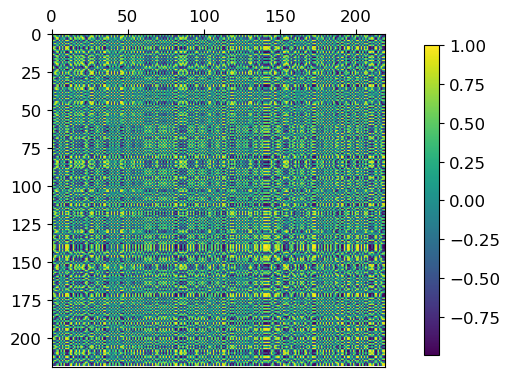

In [187]:
GramMatrix = np.inner(data_scaled, data_scaled)
GramMatrix_scaled = center_and_normalise_kernel(GramMatrix)

# heatmap + color map
fig, ax = plt.subplots(figsize=(5, 5))
plot = ax.imshow(GramMatrix_scaled) 

# set axes boundaries
ax.set_xlim([0, data.shape[0]]) ; ax.set_ylim([0, data_scaled.shape[0]])

# flip the y-axis
ax.invert_yaxis() ; ax.xaxis.tick_top()

# plot colorbar to the right
plt.colorbar(plot, pad=0.1, fraction=0.04)

### Q17
__Question 17:__ What do you observe now?

__Answer 17:__ We do not see any particular pattern, and we can suppose that a linear kernel can not be used for simple classification in this case.

## 6. Nonlinear Kernel SVM

### Gaussian RBF Kernel

We will use a **RBF kernel** or **Gaussian Radial kernel**, for several values ​​of the gamma parameter. In class we gave the formula of the Gaussian kernel:

$k(x, x') = \exp\bigg[-\frac{||x - x'||^2}{2 \sigma^2}\bigg]$

Another definition involves the gamma parameter, $\gamma=\frac{1}{2 \sigma^{2}}$ :

$k(x,x')=\exp\bigg[(-\gamma\||x - x'||^2\bigg]$

Gamma is proportional to the inverse of the square of sigma, which corresponds to the *bandwidth* of the kernel, or more intuitively the radius of influence of the train set observations.
If **sigma is large** (so **gamma small**) then the train set observations will have a long-range influence, and the majority of them will have an influence on the decision boundary.
This will therefore be "coarse" and smooth, even if some predictions are wrong.

If **sigma is small** (so **gamma large**) then the train set observations will have a short-range influence, and only those close to the decision boundary will have a local influence.
The decision boundary will therefore be "precise" but we will tend to overfit.

You can find a clear and detailed explanation  here: https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html

### Gaussian kernel SVM (gamma=100)

In [188]:
# initialisation
model_svc_rbf = svm.SVC(kernel='rbf', C=10, gamma=100)

# training
model_svc_rbf.fit(data_scaled, labels)

SVC(C=10, gamma=100)

Let's display the predictor's performance:

In [189]:
print(f"Gaussian Kernel SVM Score (C=10, gamma=100): {model_svc_rbf.score(data_scaled, labels):.3f}")

Gaussian Kernel SVM Score (C=10, gamma=100): 0.982


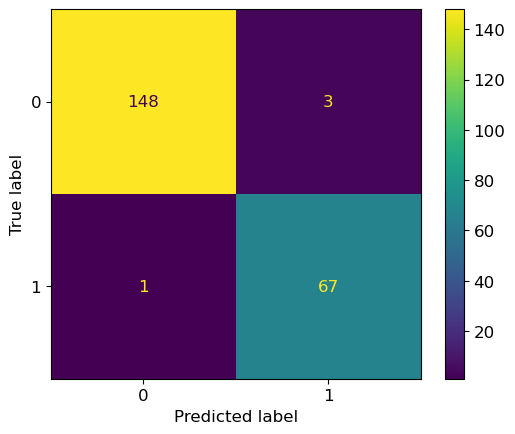

In [190]:
metrics.ConfusionMatrixDisplay.from_predictions(labels, model_svc_rbf.predict(data_scaled))

Alternatively :

In [191]:
metrics.confusion_matrix(labels, model_svc_rbf.predict(data_scaled))

array([[148,   3],
       [  1,  67]])

### Q18
__Question 18:__ Does this performance meet your expectations?

__Answer 18:__ We see that a rbf kernel model could be able to better distinguish the two classes when they are linearly inseparable. However, further we will see that here the model is simply overfitting and thus can not be generalized to new data that was not seen in the training phase. 

#### Decision boundary

We can now visualize the decision boundary:

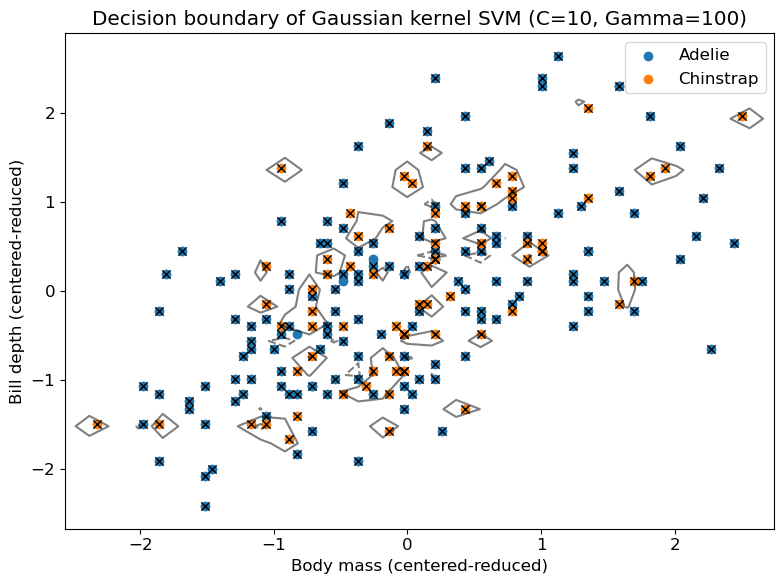

In [192]:
plt.figure(figsize=(8, 6))

# data display (Adelie penguins)
adelie_indices = np.where(labels==0)[0]
adelie = plt.scatter(data_scaled[adelie_indices][:, 0], 
                    data_scaled[adelie_indices][:, 1], 
                    label = 'Adelie')

# data display (Gentoo penguins)
gentoo_indices = np.where(labels==1)[0]
gentoo = plt.scatter(data_scaled[gentoo_indices][:, 0], 
                    data_scaled[gentoo_indices][:, 1], 
                    label = 'Chinstrap')


# Frame limits
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Mark the support vectors with a cross
ax.scatter(model_svc_rbf.support_vectors_[:, 0], 
           model_svc_rbf.support_vectors_[:, 1], 
           linewidth=1, 
           marker='x', 
           color='k')

#   Grid of points on which to apply the model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
# Predict for the grid points
Z = model_svc_rbf.decision_function(xy).reshape(XX.shape)

# Show decision boundary and margin
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], 
           alpha=0.5, linestyles=['--', '-', '--'])

# Legend
plt.legend()
plt.xlabel("Body mass (centered-reduced)")
plt.ylabel("Bill depth (centered-reduced)")
plt.title("Decision boundary of Gaussian kernel SVM (C=10, Gamma=100)")
plt.tight_layout()

### Q19
__Question 19:__ What do you think about this decision boundary? Is there a risk of overfitting?

__Answer 19:__ Yes, the model is overfitted and can not be generalised to a new previously unseen data.

#### Gram matrix

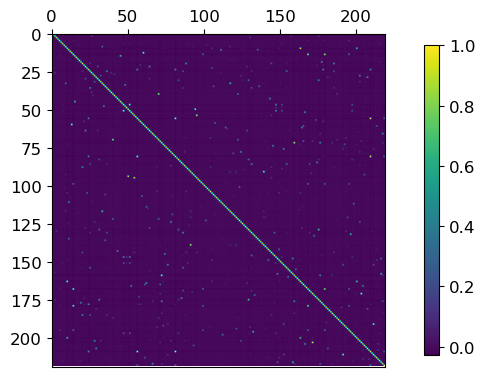

In [193]:
GramMatrix = metrics.pairwise.rbf_kernel(data_scaled, gamma=100)
GramMatrix_scaled = center_and_normalise_kernel(GramMatrix)

# heatmap + color map
fig, ax = plt.subplots(figsize=(5, 5))
plot = ax.imshow(GramMatrix_scaled) 

# set axes boundaries
ax.set_xlim([0, data.shape[0]]) ; ax.set_ylim([0, data_scaled.shape[0]])

# flip the y-axis
ax.invert_yaxis() ; ax.xaxis.tick_top()

# plot colorbar to the right
plt.colorbar(plot, pad=0.1, fraction=0.04)

### Q20

__Question 20:__ What do you think of this Gram matrix?

__Answer 20:__ This kernel is almost always zero for two points. The few cases where it is not do not seem to correlate strongly with classes.

### Generalization

Does this model __generalize__ well, in other words, will it be able to make good predictions on new data that we did not use to build it?

To find out, we will split the data into a __training set__ and a __testing set__. We will train our SVMs on the training set only, and measure their performance on the testing set. The testing set, being unknown at the time of training, is considered new data. To do this, we will use the [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function of scikit-learn.

We need to split on the unstandardized variables, standardize the training set, and then standardize the testing set based on the variance and mean of the train set variables.

In [194]:
from sklearn import model_selection

In [195]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(data, 
                                                                    labels, 
                                                                    test_size=.2, 
                                                                    random_state=2024)

In [196]:
std_scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = std_scaler.transform(X_train)
X_test_scaled = std_scaler.transform(X_test)

We will now calculate the _accuracy_ of an SVM on the training set and on the test set for several values ​​of `gamma`:

In [197]:
gamma_values = np.linspace(0.01, 200, 20)

In [198]:
acc_train, acc_test = list(), list()

for param in gamma_values:
    # Initialisation
    clf = svm.SVC(kernel='rbf', C=10, gamma=param)
    # Training
    clf.fit(X_train_scaled, y_train)
    # Accuracy on training set
    acc_train.append(clf.score(X_train_scaled, y_train))
    # Accuracy on test set
    acc_test.append(clf.score(X_test_scaled, y_test))

Let's plot the performance as a function of the tested `gamma` values.

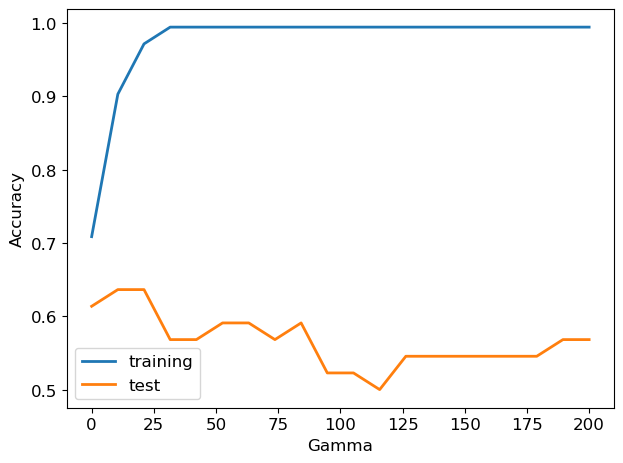

In [199]:
plt.plot(gamma_values, acc_train, label='training', lw=2)
plt.plot(gamma_values, acc_test, label='test', lw=2)

# add a legend
plt.legend(loc='best')

# format the plot
plt.xlabel("Gamma")
plt.ylabel("Accuracy")
plt.tight_layout()

plt.show()

### Q21

__Question 21:__ Is there overfitting? For what gamma values?

__Answer 21:__ Yes, the training accuracy grows high very quickly, while the test accuracy drops and remain unstable after values $gamma \approx 5-10$. As random performance is $ \approx 0.69$, the test accuracy is never good enough.

#### Selection of gamma and C by cross-validation

We will now select `gamma` and `C` by cross-validation on the training set. Let's start by defining the grid:

In [200]:
gamma_values = np.logspace(-1, 3, 10)
C_values = np.array([1., 10., 100., 500, 1000])

We can now use [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html):

In [201]:
# Instantiation of a GridSearchCV object
grid_svc = model_selection.GridSearchCV(svm.SVC(kernel='rbf'), # predictor to evaluate
                                       {'gamma': gamma_values, 'C': C_values}, # dictionary of hyperparameter values
                                       cv=5, # use 5 fold cross validation
                                       scoring='accuracy' # performance evaluation metric
                                       )

In [202]:
%%time

# Using this object on training data
grid_svc.fit(X_train_scaled, y_train)

CPU times: user 2.1 s, sys: 1.72 ms, total: 2.1 s
Wall time: 2.11 s


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': array([   1.,   10.,  100.,  500., 1000.]),
                         'gamma': array([1.00000000e-01, 2.78255940e-01, 7.74263683e-01, 2.15443469e+00,
       5.99484250e+00, 1.66810054e+01, 4.64158883e+01, 1.29154967e+02,
       3.59381366e+02, 1.00000000e+03])},
             scoring='accuracy')

The optimal value of the hyperparameters is given by:

In [203]:
print(grid_svc.best_params_)

{'C': np.float64(1.0), 'gamma': np.float64(129.15496650148827)}


Let's visualize the accuracy as a function of `C` and `gamma`:

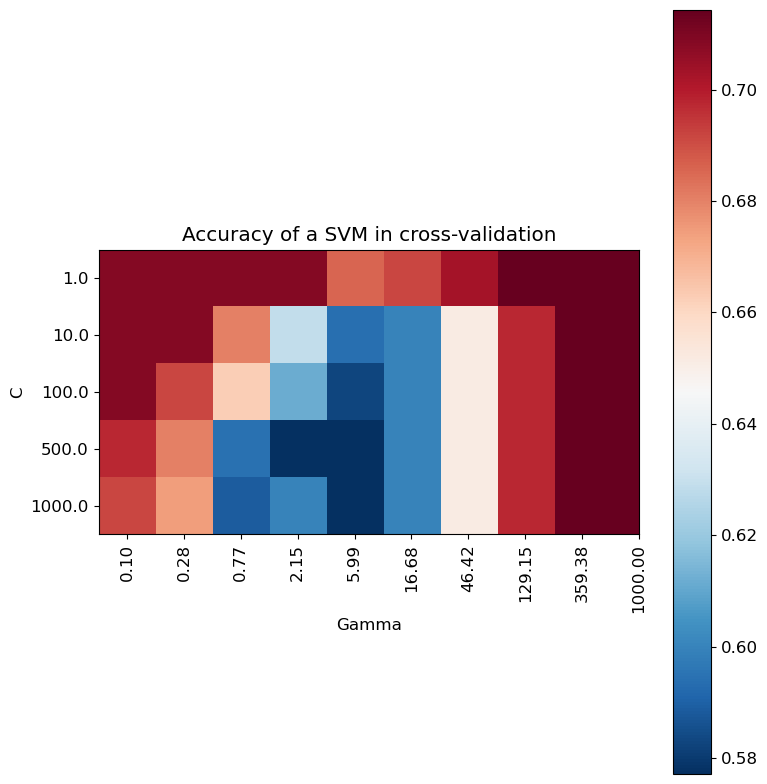

In [204]:
plt.figure(figsize=(8, 8))

# reorganize the results of the grid search
scores = grid_svc.cv_results_['mean_test_score'].reshape(len(C_values), len(gamma_values))

# heatmap
plt.imshow(scores, interpolation='none', cmap="RdBu_r")

# colorbar
plt.colorbar()

# Legend
plt.title("Accuracy of a SVM in cross-validation")
plt.ylabel("C")
plt.xlabel("Gamma")
plt.xlim((-0.5, 3.5))
plt.yticks(np.arange(len(C_values)), C_values)
plt.xticks(np.arange(len(gamma_values)), ["%.2f" % x for x in gamma_values], rotation=90)
plt.tight_layout()

#### Performance of SVM with optimal hyperparameter on the test set

In [205]:
svc_best = grid_svc.best_estimator_

In [206]:
print(f"Score on the Gaussian kernel SVM test set (optimized C and gamma): {svc_best.score(X_test_scaled, y_test):.3f}")

Score on the Gaussian kernel SVM test set (optimized C and gamma): 0.591


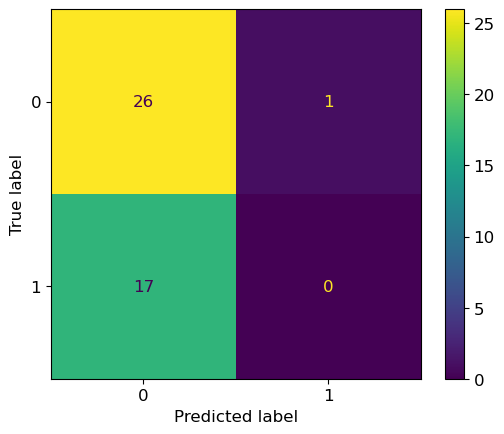

In [207]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, svc_best.predict(X_test_scaled))

Alternatively :

In [208]:
metrics.confusion_matrix(y_test, svc_best.predict(X_test_scaled))

array([[26,  1],
       [17,  0]])

### Q22

__Question__:  From the confusion matrix, do you think that this classification is accurate? Can the problem be solved with a non-linear SVM? 

__Answer__: No, the model again assigns the `0` label to almost all samples and thus does not accurately separate the classes.

## 7. Nonlinear kernel SVM on a simpler problem

In [209]:
labels = penguins_labels[penguins_labels["species_int"].isin([0,1])]
labels = np.array(labels["species_int"])
print("shape de y:", labels.shape)

data = penguins_features[penguins_labels["species_int"].isin([0,1])] 
data = np.array(data[["body_mass_g", "bill_length_mm"]])
print("shape de X:", data.shape)

shape de y: (219,)
shape de X: (219, 2)


In [210]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(data, 
                                                                    labels, 
                                                                    test_size=.2, 
                                                                    random_state=21)

In [211]:
std_scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = std_scaler.transform(X_train)
X_test_scaled = std_scaler.transform(X_test)

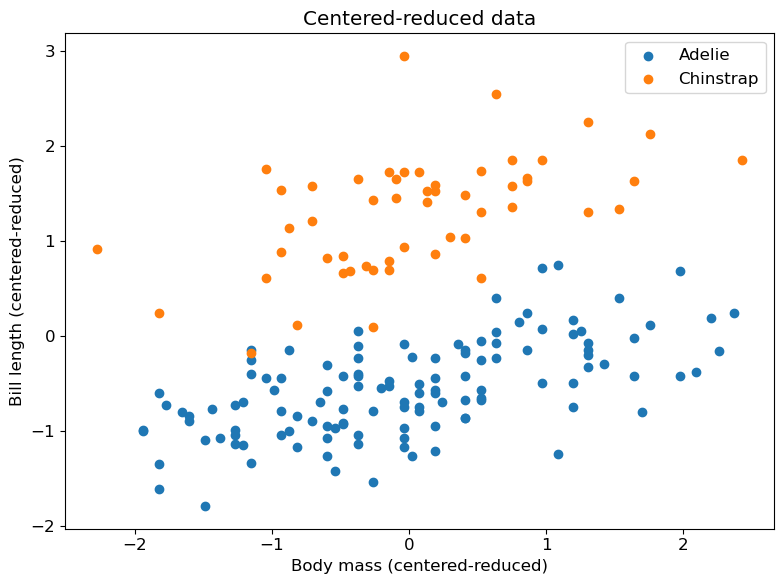

In [212]:
plt.figure(figsize=(8, 6))

# afficher les données (pingouins Adelie)
adelie_indices = np.where(y_train==0)[0]
adelie = plt.scatter(X_train_scaled[adelie_indices][:, 0], 
                    X_train_scaled[adelie_indices][:, 1], 
                    label = 'Adelie')

# afficher les données (pingouins Chinstrap)
gentoo_indices = np.where(y_train==1)[0]
gentoo = plt.scatter(X_train_scaled[gentoo_indices][:, 0], 
                    X_train_scaled[gentoo_indices][:, 1], 
                    label = 'Chinstrap')

# Légende
plt.legend()
plt.xlabel("Body mass (centered-reduced)")
plt.ylabel("Bill length (centered-reduced)")
plt.title("Centered-reduced data")
plt.tight_layout()

In [213]:
gamma_values = np.logspace(-1, 3, 10)
C_values = np.array([1., 10., 100., 500, 1000])

We can now use [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html):

In [214]:
# Instantiating a GridSearchCV object
grid_svc = model_selection.GridSearchCV(svm.SVC(kernel='rbf'), # predictor to be evaluated
                                       {'gamma': gamma_values, 'C': C_values}, # hyperparameter value dictionary
                                       cv=5, # use 5 fold cross validation
                                       scoring='accuracy' # performance evaluation metric
                                       )

In [215]:
%%time

# Using this object on training data
grid_svc.fit(X_train_scaled, y_train)

CPU times: user 739 ms, sys: 3.84 ms, total: 743 ms
Wall time: 746 ms


GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': array([   1.,   10.,  100.,  500., 1000.]),
                         'gamma': array([1.00000000e-01, 2.78255940e-01, 7.74263683e-01, 2.15443469e+00,
       5.99484250e+00, 1.66810054e+01, 4.64158883e+01, 1.29154967e+02,
       3.59381366e+02, 1.00000000e+03])},
             scoring='accuracy')

The optimal value of the hyperparameters is given by:

In [216]:
print(grid_svc.best_params_)

{'C': np.float64(500.0), 'gamma': np.float64(0.2782559402207124)}


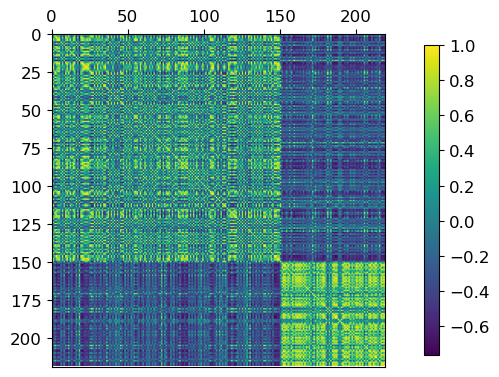

In [217]:
# standardization (center-reduce)
std_scaler = preprocessing.StandardScaler().fit(data)
data_scaled = std_scaler.transform(data)


GramMatrix = metrics.pairwise.rbf_kernel(data_scaled, gamma=grid_svc.best_params_['gamma'])
GramMatrix_scaled = center_and_normalise_kernel(GramMatrix)

# heatmap + color map
fig, ax = plt.subplots(figsize=(5, 5))
plot = ax.imshow(GramMatrix_scaled) 

# set axes boundaries
ax.set_xlim([0, data.shape[0]]) ; ax.set_ylim([0, data_scaled.shape[0]])

# flip the y-axis
ax.invert_yaxis() ; ax.xaxis.tick_top()

# plot colorbar to the right
plt.colorbar(plot, pad=0.1, fraction=0.04)

Let's visualize the accuracy as a function of `C` and `gamma`:

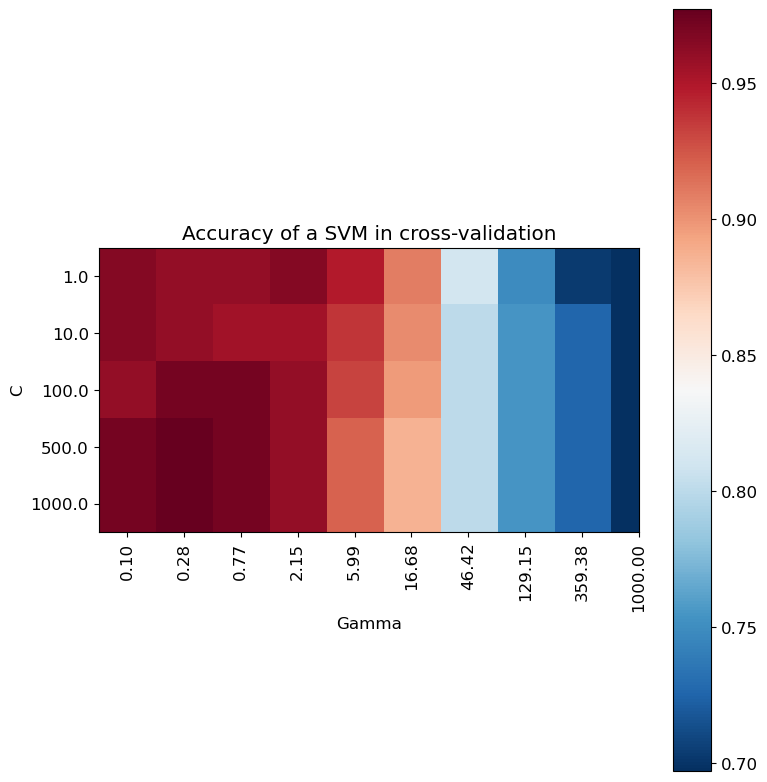

In [218]:
plt.figure(figsize=(8, 8))

# réarrangement des résultats
scores = grid_svc.cv_results_['mean_test_score'].reshape(len(C_values), len(gamma_values))

# heatmap
plt.imshow(scores, interpolation='none', cmap="RdBu_r")

# colorbar
plt.colorbar()

# Légende
plt.title("Accuracy of a SVM in cross-validation")
plt.ylabel("C")
plt.xlabel("Gamma")
plt.xlim((-0.5, 3.5))
plt.yticks(np.arange(len(C_values)), C_values)
plt.xticks(np.arange(len(gamma_values)), ["%.2f" % x for x in gamma_values], rotation=90)
plt.tight_layout()

In [219]:
svc_best = grid_svc.best_estimator_

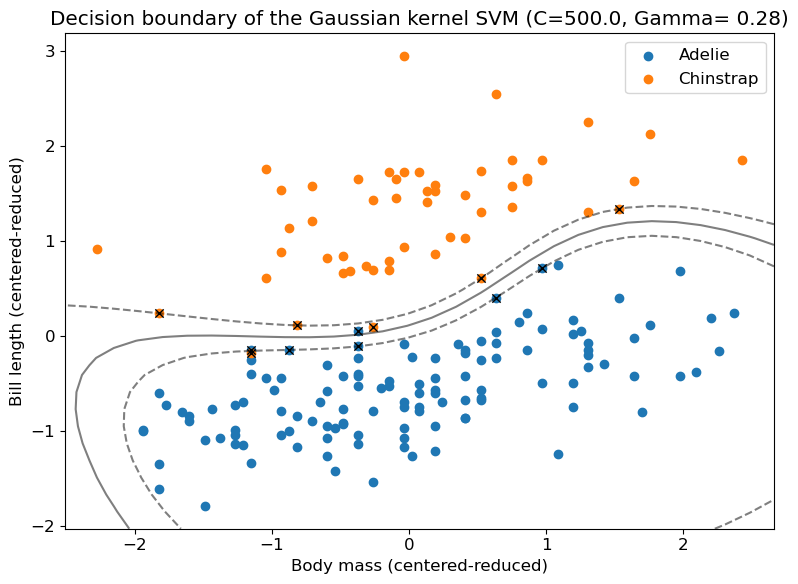

In [220]:
plt.figure(figsize=(8, 6))

# show data (pingouins Adelie)
adelie_indices = np.where(y_train==0)[0]
adelie = plt.scatter(X_train_scaled[adelie_indices][:, 0], 
                    X_train_scaled[adelie_indices][:, 1], 
                    label = 'Adelie')

# show data (pingouins Chinstrap)
gentoo_indices = np.where(y_train==1)[0]
gentoo = plt.scatter(X_train_scaled[gentoo_indices][:, 0], 
                    X_train_scaled[gentoo_indices][:, 1], 
                    label = 'Chinstrap')


# Frame limits
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Mark the support vectors with a cross
ax.scatter(svc_best.support_vectors_[:, 0], 
           svc_best.support_vectors_[:, 1], 
           linewidth=1, 
           marker='x', 
           color='k')

# Grid of points on which to apply the model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
# Predict for the grid points
Z = svc_best.decision_function(xy).reshape(XX.shape)

# Show decision boundary and margin
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], 
           alpha=0.5, linestyles=['--', '-', '--'])

# Legend
plt.legend()
plt.xlabel("Body mass (centered-reduced)")
plt.ylabel("Bill length (centered-reduced)")
plt.title(f"Decision boundary of the Gaussian kernel SVM (C={svc_best.C}, Gamma={svc_best.gamma: .2f})")
plt.tight_layout()

In [221]:
print(f"Score on the Gaussian kernel SVM test set (optimized C and gamma): {svc_best.score(X_test_scaled, y_test):.3f}")

Score on the Gaussian kernel SVM test set (optimized C and gamma): 0.955


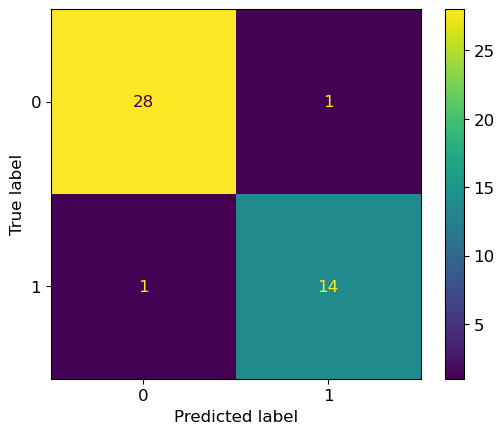

In [222]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, svc_best.predict(X_test_scaled))

Alternatively:

In [223]:
metrics.confusion_matrix(y_test, svc_best.predict(X_test_scaled))

array([[28,  1],
       [ 1, 14]])

### Q22: Application

### 1) SVM on 4 features

Select the best SVM parameters for classification with the 4 features (*bill_depth_mm*,  *bill_length_mm*, *flipper_length_mm* and *body_mass_g*).

__Question :__ Train a classification SVM to separate the species Adelie vs Chinstrap. Train your SVM in cross-validation on the training set. What parameters can you vary? What is the performance of your optimal model _on the test set_? 

### 2) Find the best pair of variables

We can use the `seaborn` package to easily examine pairs of variables two by two and deduce which ones are most useful for separating classes:

In [224]:
penguins_adelie_chinstrap = pd.concat([penguins_features[penguins_labels["species_int"].isin([0,1])],
                                    penguins_labels[penguins_labels["species_int"].isin([0,1])]],
                                     axis = 1)

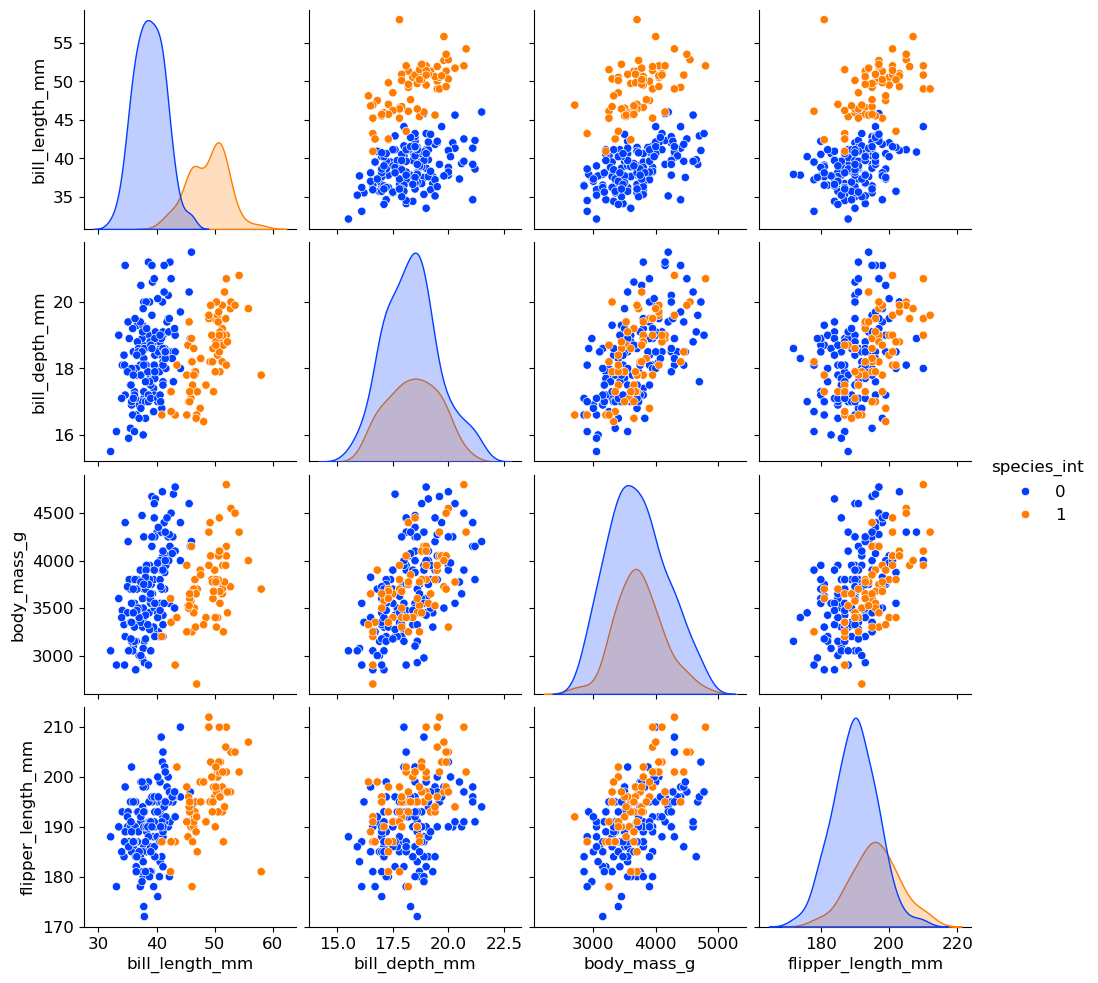

In [225]:
import seaborn as sns
sns.pairplot(penguins_adelie_chinstrap, hue="species_int",palette="bright")

__Question :__  Select the best 2 features and train a classification SVM to separate the species Adelie vs Chinstrap. 

Compare to the precedent results.
__Answer :__  

### 3) Multiclass SVM (bonus)

__Question:__ How would you build a multi-class model, based on SVMs, that assigns a new observation to one of the three species Adélie (0), Chinstrap (1) or Gentoo (2)? Make a plot of the confident matrix and in 2D to visualize the results.
